# Notebook for Data Modelling.

<span style="font-size: larger;">**Continued from Data Preprocessing Notebook:**</span>

As we've came up with a final dataset that is cleaned, preprocessed and many irrelevant features dropped - now it's time to dig deeper into ML modelling, trying to make our best in creating reliable data models.

<span style="font-size: larger;">**Proposed Solution:**</span>

In order to prepare tada and have all the methods reproducable my is as follows:
* Unified approach for feature engineering.
* Unified approach for feature encoding.
* Perform cross validation;
* Tune model on the AUC score.
* Evaluate predictions.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tools
from sklearn.preprocessing import FunctionTransformer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
warnings.filterwarnings("ignore")

In [8]:
file_path = '/Users/taurasaleksandravicius/Desktop/Personal/TC/Projects/taleks-ML.4.1/'

df = pd.read_csv(f"{file_path}final_df.csv", index_col = 0)

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR_COUNT_PRV,AMT_ANNUITY_MEAN_PRV,AMT_ANNUITY_SUM_PRV,AMT_CREDIT_MEAN_PRV,AMT_CREDIT_SUM_PRV,DAYS_DECISION_MEAN_PRV,CNT_PAYMENT_MEAN_PRV,CNT_PAYMENT_SUM_PRV,RATE_DOWN_PAYMENT_MEAN_PRV,DAYS_LAST_DUE_MEAN_PRV,DAYS_TERMINATION_MEAN_PRV,NAME_CONTRACT_STATUS_PRV,PRODUCT_COMBINATION_PRV,NAME_YIELD_GROUP_PRV,STATUS_APPROVED_COUNT_PRV,STATUS_CANCELED_COUNT_PRV,STATUS_REFUSED_COUNT_PRV,CREDIT_DAY_OVERDUE_BUR,DAYS_CREDIT_ENDDATE_BUR,AMT_CREDIT_SUM_BUR,AMT_CREDIT_SUM_DEBT_BUR,AMT_CREDIT_SUM_OVERDUE_BUR,CNT_CREDIT_PROLONG_BUR,CREDIT_ACTIVE_BUR,CNT_INSTALMENT_POS,CNT_INSTALMENT_FUTURE_POS,NAME_CONTRACT_STATUS_POS,SK_DPD_POS,SK_DPD_DEF_POS,COUNT_ON_TIME_PAYMENTS_INST,COUNT_LATE_PAYMENTS_INST
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,0,1,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,-1134.0,1,0,0,0.0,0.0,0.0,1.0,1.0,9251.775,9251.775,179055.00,179055.0,-606.000000,24.000000,24.0,0.000000,-25.000000,-17.000000,Approved,POS other with interest,low_normal,1.0,0.0,0.0,0.0,-349.0,108131.945625,49156.2,0.0,0.0,Closed,24.0,6.0,Active,0.0,0.0,19.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,0,1,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,1.0,0.0,1.0,-828.0,1,0,0,0.0,0.0,0.0,0.0,3.0,56553.990,169661.970,484191.00,1452573.0,-1305.000000,10.000000,30.0,0.050030,-1054.333333,-1047.333333,Approved,Cash X-Sell: low,middle,3.0,0.0,0.0,0.0,-544.5,254350.125000,0.0,0.0,0.0,Active,7.0,0.0,Completed,0.0,0.0,25.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.0,0.0,0.0,-815.0,0,0,0,0.0,0.0,0.0,0.0,1.0,5357.250,5357.250,20106.00,20106.0,-815.000000,4.000000,4.0,0.212008,-724.000000,-714.000000,Approved,POS mobile without interest,middle,1.0,0.0,0.0,0.0,-488.5,94518.900000,0.0,0.0,0.0,Closed,3.0,0.0,Completed,0.0,0.0,3.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,2.0,0.0,2.0,-617.0,1,0,0,NaN,NaN,NaN,NaN,9.0,23651.175,141907.050,291695.50,2625259.5,-272.444444,23.000000,138.0,0.163412,182477.500000,182481.750000,Approved,Cash,XNA,5.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,3.0,Active,0.0,0.0,16.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religi

**Let's memorize some feature engineering ideas that I've came up after EDA Part II.:**
* Calculate Annuity to Income Ratio;
* Calculate Annuity Length;
* Calculate Credit - Goods Price;
* Calculate Credit to Goods Price Ratio;
* Calculate Credit to Anuity Ratio
* Calculate Credit to Total Income Ratio.
* Working Life Ratio;
* Income per Family Member;
* Children ratio;
* Interaction between AMT_ANNUITY, EXT_SOURCE_2 and EXT_SOURCE_3.

## Feature Engineering:

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = tools.stratified_train_val_test_split(df, target_col='TARGET')

Things to do from previous analyses:
* Fill OCCUPATION_TYPE missing values with 'Unknown'
* df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
* impute categoricals with mode and numerics with median value;

In [9]:
def feature_engineering(df):
    
    # Data Cleaning Steps first;
    df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)

    # Creating new features
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['AMT_CREDIT-AMT_GOODS_PRICE'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['AMT_CREDIT/AMT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['AMT_CREDIT/AMT_ANNUITY'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['AMT_CREDIT/AMT_INCOME_TOTAL'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['WORKING_LIFE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_PER_FAM'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
    
    df['EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCE_2^2'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_2']
    df['EXT_SOURCE_3^2'] = df['EXT_SOURCE_3'] * df['EXT_SOURCE_3']
    df['ANNUITY*EXT_SOURCE_2'] = df['AMT_ANNUITY'] * df['EXT_SOURCE_2']
    df['ANNUITY*EXT_SOURCE_3'] = df['AMT_ANNUITY'] * df['EXT_SOURCE_3']
    return df

feature_engineer = FunctionTransformer(feature_engineering)

Great! Let's create baseline model for the beginning.

## Baseline Model.

In [30]:
numerical_features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
    'CNT_CHILDREN', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
    'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 
    'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
    'SK_ID_CURR_COUNT_PRV', 'AMT_ANNUITY_MEAN_PRV', 'AMT_ANNUITY_SUM_PRV', 
    'AMT_CREDIT_MEAN_PRV', 'AMT_CREDIT_SUM_PRV', 'DAYS_DECISION_MEAN_PRV', 
    'CNT_PAYMENT_MEAN_PRV', 'CNT_PAYMENT_SUM_PRV', 'RATE_DOWN_PAYMENT_MEAN_PRV', 
    'DAYS_LAST_DUE_MEAN_PRV', 'DAYS_TERMINATION_MEAN_PRV', 
    'CREDIT_DAY_OVERDUE_BUR', 'DAYS_CREDIT_ENDDATE_BUR', 'AMT_CREDIT_SUM_BUR', 
    'AMT_CREDIT_SUM_DEBT_BUR', 'AMT_CREDIT_SUM_OVERDUE_BUR', 
    'CNT_CREDIT_PROLONG_BUR', 'CNT_INSTALMENT_POS', 'CNT_INSTALMENT_FUTURE_POS', 
    'SK_DPD_POS', 'SK_DPD_DEF_POS', 'COUNT_ON_TIME_PAYMENTS_INST', 
    'COUNT_LATE_PAYMENTS_INST',  'ANNUITY_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO',
    'AMT_CREDIT-AMT_GOODS_PRICE','AMT_CREDIT/AMT_GOODS_PRICE','AMT_CREDIT/AMT_ANNUITY',
    'AMT_CREDIT/AMT_INCOME_TOTAL','WORKING_LIFE_RATIO','INCOME_PER_FAM','CHILDREN_RATIO',
    'EXT_SOURCE_2 * EXT_SOURCE_3','EXT_SOURCE_2^2','EXT_SOURCE_3^2','ANNUITY*EXT_SOURCE_2',
    'ANNUITY*EXT_SOURCE_3'
]

categorical_features = [
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
    'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 
    'ORGANIZATION_TYPE', 'NAME_CONTRACT_STATUS_PRV', 'PRODUCT_COMBINATION_PRV', 
    'NAME_YIELD_GROUP_PRV'
]

binary_features = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 
    'FLAG_OWN_REALTY', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 
    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8'
]

In [66]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import FunctionTransformer

def label_encode(X):
    return X.apply(lambda col: LabelEncoder().fit_transform(col))

def label_encode_transform(X):
    return pd.DataFrame(label_encode(pd.DataFrame(X)))
    
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', FunctionTransformer(label_encode_transform, validate=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('bin', binary_pipeline, binary_features)
    ])

In [67]:
xgb_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',
        max_depth=6,            
        min_child_weight=1,     
        subsample=0.8,          
        colsample_bytree=0.8,  
        learning_rate=0.1,    
        n_estimators=100,      
        objective='binary:logistic'
    ))])

xgb_pipeline.fit(X_train, y_train)

xgb_predictions_proba = xgb_pipeline.predict_proba(X_val)[:, 1]

xgb_auc = roc_auc_score(y_val, xgb_predictions_proba)
print("AUC Score:", xgb_auc)

AUC Score: 0.7664953536853369


Let's take a look at the shap values which show feature importances.

In [42]:
def plot_shap(model_pipeline, X_train):
    
    X_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train)
    
    num_feature_names = numerical_features
    cat_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
    bin_feature_names = binary_features
    
    feature_names = np.concatenate([num_feature_names, cat_feature_names, bin_feature_names])
    
    explainer = shap.TreeExplainer(model_pipeline.named_steps['classifier'])
    shap_values = explainer.shap_values(X_transformed)
    
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

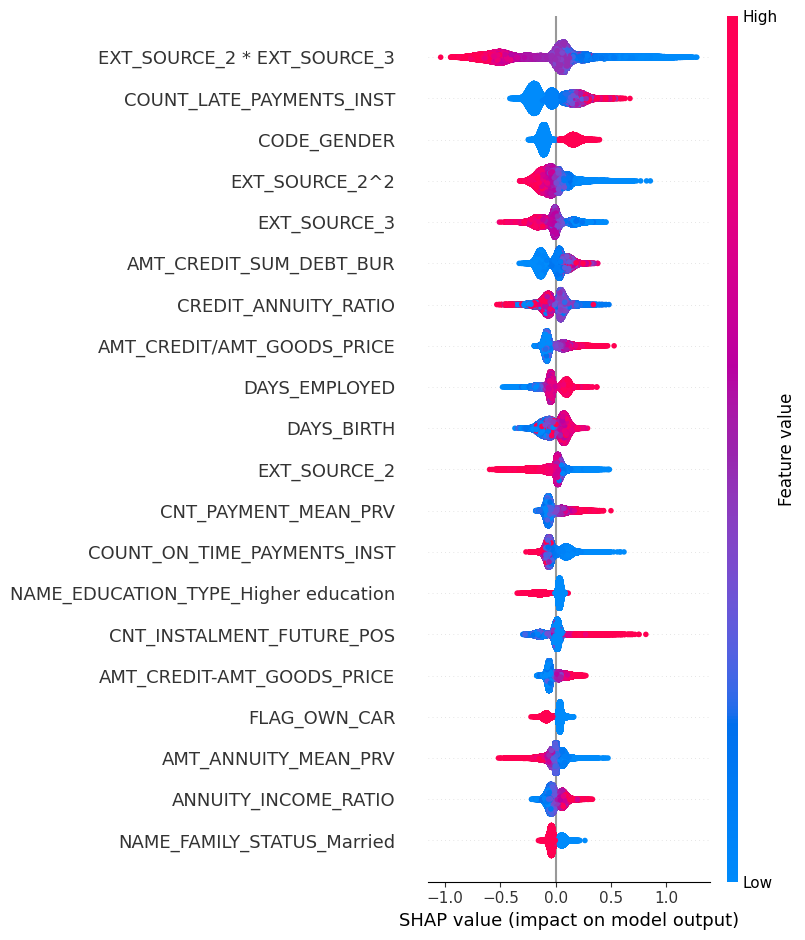

In [43]:
plot_shap(xgb_pipeline, X_train)

**And try LGBM Classifier.**

In [54]:
lgbm_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        subsample=0.8,
        reg_lambda = 0.1,
        learning_rate=0.05,
        n_estimators=100,
        objective='binary',
        verbose= -1
    ))
])

lgbm_pipeline.fit(X_train, y_train)

lgbm_predictions_proba = lgbm_pipeline.predict_proba(X_val)[:, 1]

lgbm_auc = roc_auc_score(y_val, lgbm_predictions_proba)
print("LightGBM AUC Score:", lgbm_auc)


LightGBM AUC Score: 0.7609473668825263


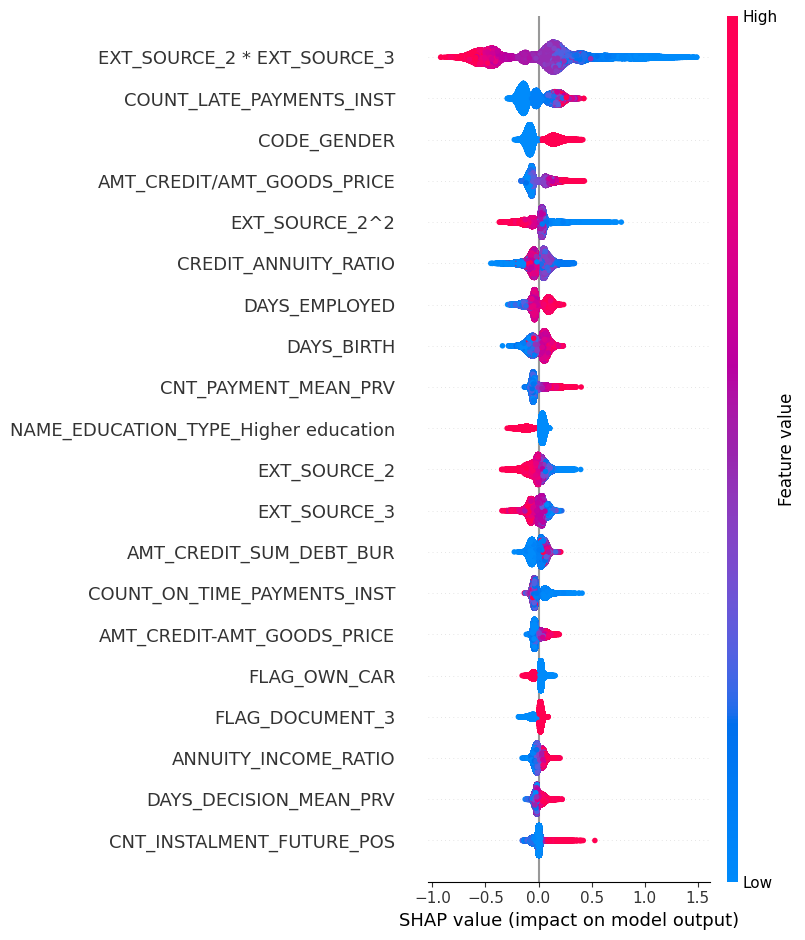

In [44]:
plot_shap(lgbm_pipeline, X_train)

Lets look at the ROC AUC Curves.

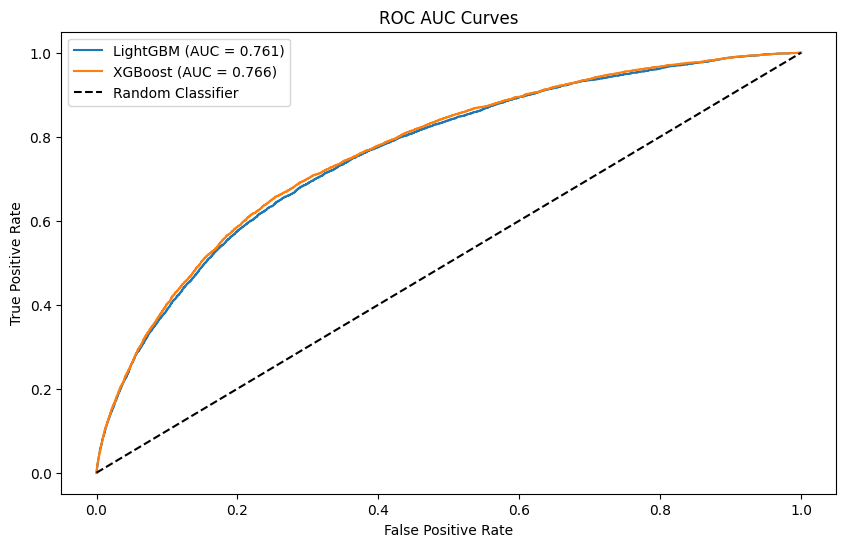

In [58]:
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_val, lgbm_predictions_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_predictions_proba)

plt.figure(figsize=(10, 6))
plt.plot(lgbm_fpr, lgbm_tpr, label=f'LightGBM (AUC = {lgbm_auc:.3f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves')
plt.legend(loc='best')
plt.show()

#### Very nice! So far everything makes a lot of sense! Lets keep up work with LGBM model and cross validation and model fine-tuning!

In [47]:
def cv_model(model, X, y, cv=3):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        predictions_proba = model.predict_proba(X_val_fold)[:, 1]

        auc = roc_auc_score(y_val_fold, predictions_proba)
        auc_scores.append(auc)

    return auc_scores

lgbm_auc_scores = cv_model(lgbm_pipeline, X_train, y_train, cv=3)

print("LightGBM Pipeline AUC Scores:", lgbm_auc_scores)


LightGBM Pipeline AUC Scores: [0.7601953672113899, 0.7588132929676235, 0.7676931592647663]


**Awesome! Model is not overfitting on the validation set!**

In [48]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 512),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e0)
    }

    lgbm_pipeline = Pipeline([
        ('feature_engineering', feature_engineer),
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            objective='binary',
            verbose=-1,
            **param_grid
        ))
    ])

    lgbm_pipeline.fit(X_train, y_train)
    predictions_proba = lgbm_pipeline.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, predictions_proba)

    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters found by Optuna: ", best_params)

[I 2024-06-09 17:30:10,472] A new study created in memory with name: no-name-b38e4303-03fc-41a0-94aa-14e1d4887802
[I 2024-06-09 17:30:28,167] Trial 0 finished with value: 0.7544885321199422 and parameters: {'n_estimators': 340, 'learning_rate': 0.005732260384699937, 'num_leaves': 166, 'max_depth': 10, 'min_child_samples': 56, 'subsample': 0.7696743854128547, 'colsample_bytree': 0.5151959441483365, 'reg_alpha': 0.5567416439133677, 'reg_lambda': 0.014132832970522455}. Best is trial 0 with value: 0.7544885321199422.
[I 2024-06-09 17:30:54,288] Trial 1 finished with value: 0.7674996891254919 and parameters: {'n_estimators': 543, 'learning_rate': 0.033867067152245495, 'num_leaves': 371, 'max_depth': 10, 'min_child_samples': 65, 'subsample': 0.5917072786430917, 'colsample_bytree': 0.5619814803539576, 'reg_alpha': 0.017155607993334408, 'reg_lambda': 0.003326584405777092}. Best is trial 1 with value: 0.7674996891254919.
[I 2024-06-09 17:31:12,740] Trial 2 finished with value: 0.762235415512700

Best hyperparameters found by Optuna:  {'n_estimators': 915, 'learning_rate': 0.044371821441811184, 'num_leaves': 236, 'max_depth': 4, 'min_child_samples': 95, 'subsample': 0.9524909756751027, 'colsample_bytree': 0.8504277004777613, 'reg_alpha': 0.03191105887274946, 'reg_lambda': 0.11147736109337684}


Best hyperparameters found by Optuna:  {'n_estimators': 915, 'learning_rate': 0.044371821441811184, 'num_leaves': 236, 'max_depth': 4, 'min_child_samples': 95, 'subsample': 0.9524909756751027, 'colsample_bytree': 0.8504277004777613, 'reg_alpha': 0.03191105887274946, 'reg_lambda': 0.11147736109337684}

**Lets Train model again and run it against Test data.**

n_estimators: 915,
learning_rate: 0.044371821441811184,
num_leaves: 236,
max_depth: 4,
min_child_samples: 95, 
subsample: 0.9524909756751027, 
colsample_bytree: 0.8504277004777613,
reg_alpha: 0.03191105887274946,
reg_lambda: 0.11147736109337684}

In [68]:
lgbm_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators= 915,
        learning_rate= 0.044371821441811184,
        num_leaves= 236,
        max_depth= 4,
        min_child_samples= 95, 
        subsample= 0.9524909756751027, 
        colsample_bytree= 0.8504277004777613,
        reg_alpha= 0.03191105887274946,
        reg_lambda= 0.11147736109337684,
        objective='binary',
        verbose= -1
    ))
])

lgbm_pipeline.fit(X_train, y_train)

lgbm_predictions_proba = lgbm_pipeline.predict_proba(X_test)[:, 1]

lgbm_auc = roc_auc_score(y_test, lgbm_predictions_proba)
print("LightGBM AUC Score:", lgbm_auc)

LightGBM AUC Score: 0.7766608401121734


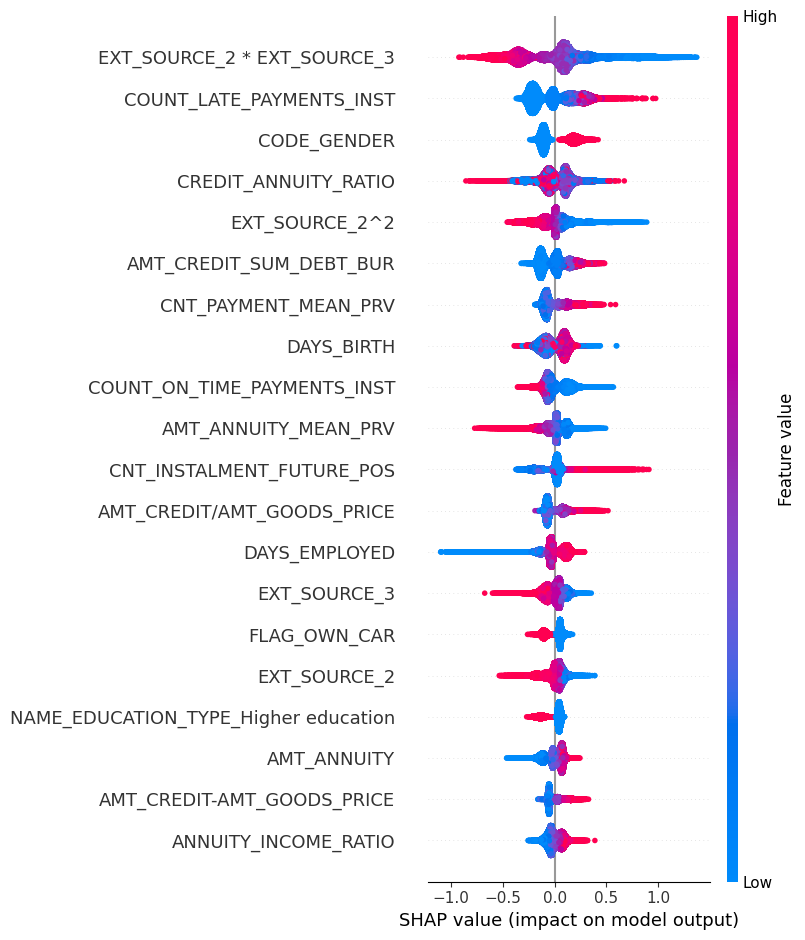

In [63]:
plot_shap(lgbm_pipeline, X_train)

# Conclusion

**Final Plan for the POC:**

- Suggest getting backend data to unified data storage;
- Create data models that aggregate data into unified dataset for models; Models are ran via DBT, orchestrated via Airflow and training data is incrementally updated on every new application.
- Having unified data model - perform data cleaning on each user_id and trained model would be accessible via web-page UI.
- User at might be requested to fill in mandatory fields.

**Conclusion from the project:**
- Most important features for the defaulting are count of late payments, gender, credit sum debt. All of them totally make sense;
- Model is capable of capturing 77%  (AUC score) of positive instances;
- Feature Engineered features and features from other datasets helped vastly. Without them model would be a lot inferior;
- This project helped develop knowledge about what is important when paying out your current debt. :) 
